## Stability finding function for delay differential equations (DDE)

Needed packages and functions for this notebook:

In [34]:
using CairoMakie
using LinearAlgebra
include("j_eval.jl")
include("j_diff.jl")
include("stab_func_DDE.jl")

stab_func_DDE (generic function with 1 method)

The stability function (```stab_func_DDE```) discussed in this notebook is from the stability idea put forward by D. Breda, S. Maset and R. Vermiglio (Breda, et al. 2009). 

The ```stab_func_DDE``` function has the following input arguments:
1. ```A``` which are matrices of the (linearised) DDE system - they should be linearised around the equilibrium point the user whishes to find the stability of. This argument should be written in the form of a vector of matrices.
2. ```taus``` are the delays. This argument should be written in vector form.
3.  ```N``` is the number of nodes for interpolation (so you get N+1 nodes) the user wishes to have
4. Optional argument: ```eigvecs``` tells the function to output the eigenvectors (in matrix form); default is ```0``` (eigenvectors not outputted) 

The ```stab_func_DDE``` function outputs the following:
1. ```stab``` is the stability of the (equilibrium) point (gives 1 if the point is stable, 0 if the point is unstable)
2. ```sm_eigvals``` are the eigenvalues of the point
3. If asked: ```sm_eigvecs``` are the eigenvectors of the eigenvalues

The theory behind ```stab_func_DDE``` ADD STUFF HERE!!!!!!!!!!! 

Below are some examples on how ```stab_func_DDE``` works:

# Example 1

Note this example is example 2 in (Breda, et al. 2009). The (already) linearised DDE system is:
```math
y'(t)=\begin{pmatrix} -6.45 & -12.1\\ 1.5 & -0.45\end{pmatrix}y(t) + \begin{pmatrix} -6 & 0\\ 1 & 0 \end{pmatrix}y(t-\tau_1) + \begin{pmatrix} 0 & 4\\ 0 & -2 \end{pmatrix}y(t-\tau_2),
```
where $\tau_1, \tau_2$ are the delays.

In [35]:
m1=2 #the dimension of the system (y is 2 dimensional)
A0_1=[-6.45 -12.1; 1.5 -0.45] #1st matrix 
A1_1=[-6 0; 1 0] #2nd matrix
A2_1=[0 4; 0 -2] #3rd matrix
tau1_1=0.2 #tau1 value taken to be 0.2 (same as (Breda, et al 2009) example)
tau2_1=0.3 #tau2 value taken to be 0.3 (same as (Breda, et al 2009) example)
N1=85

stab1, eigvals1, eigvecs1=stab_func_DDE([A0_1, A1_1, A2_1],[tau1_1, tau2_1],N1, eigvecs=1) #the function outputs the stability, eigenvalues and eigenvectors (eigvecs≠0)

(1, ComplexF64[-2341.3676131275674 - 565.6643628872978im, -2341.3676131275674 + 565.6643628872978im, -1629.8512288762383 - 1284.981165568297im, -1629.8512288762383 + 1284.981165568297im, -1082.4652661115333 - 4134.383618756369im, -1082.4652661115333 + 4134.383618756369im, -1082.437483845873 - 4134.378478615176im, -1082.437483845873 + 4134.378478615176im, -896.4918810628548 - 1362.6056234012196im, -896.4918810628548 + 1362.6056234012196im  …  -10.481054578907505 - 68.823277039588im, -10.481054578907505 + 68.823277039588im, -10.400097260715981 - 38.925980301361335im, -10.400097260715981 + 38.925980301361335im, -9.345073381117444 - 25.570713089542068im, -9.345073381117444 + 25.570713089542068im, -5.056779280390666 - 4.026235533849968im, -5.056779280390666 + 4.026235533849968im, -1.33526847606074 - 9.11948334740251im, -1.33526847606074 + 9.11948334740251im], ComplexF64[0.0005416689674383441 - 0.00013104787813780902im 0.0005416689674383441 + 0.00013104787813780902im … -0.07797457924253481 -

The eigenvalues of a system, with $d$ delays and $m$ equations, must fulfill the property:
```math
\begin{equation}
[\lambda I - A_0 - A_1 e^{-\lambda \tau_1}-...-A_d e^{-\lambda \tau_d}]v=0 \tag{1}
\end{equation}
``` 
To check the accuracy of ```stab_func_DDE```, each eigenvalue $\lambda_j$ for $j=1,...,m*(N+1)$ is put into Equation (1) with the first eigenvalues first eigenvector outputted by ```stab_func_DDE```.

For this example, we check that $\lambda_j$ for $j=1,...172$ (since $m=2, N=85$) fulfills:
```math
[\lambda_j I - A_0 - A_1 e^{-\lambda_j \tau_1}-...-A_2 e^{-\lambda_j \tau_2}]v_j=0,
```
where $v_j$ is the first eigenvector of eigenvalue $\lambda_j$.

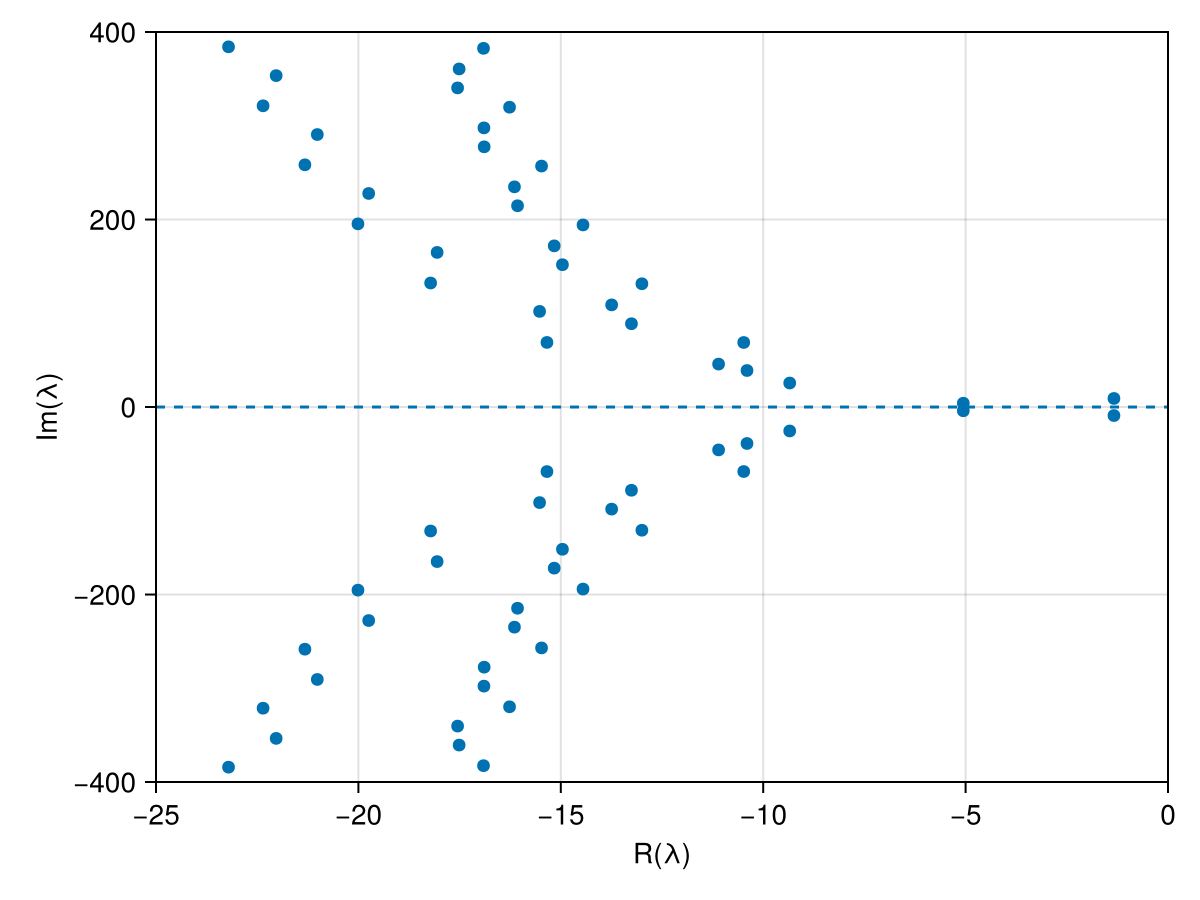

In [36]:
neigs=length(eigvals1) #number of eigenvalues 

vjvec=[fill(0.0+0*im, m1) for _ in 1:neigs] #creates blank array for first eigenvector for the eigenvalues

for i in 1:neigs
    vjvec[i]=eigvecs1[:,i][1:m1] #finds first eigenvector for the eigenvalues
end 

stab_err=fill(NaN, neigs) #creates blank array for the error of stab_func_DDE
Idm1=Matrix{Float64}(I,m1,m1) #creates 2x2 identity matrix 

for k in 1:neigs
    ceq_vec=(eigvals1[k]*Idm1 - A0_1 - A1_1*exp(-(eigvals1[k]*tau1_1))- A2_1*exp(-(eigvals1[k]*tau2_1)))*vjvec[k] #finds the value of Equation (1) 
    #CHECK THE ABOVE EQUATION LABEL!!!!!
    comp_vec=ceq_vec-[0,0]
    stab_err[k]=norm(comp_vec) #finds the error of stab_func_DDE
end 

#Assume we accept a tolerance of 10^-7 (1e-7) from 0 we find all eigenvalues that are at least of this tolerance
stab_acc_indx=findall(<=(1e-7),stab_err) #finds indices of eigenvalues that are at least of accuracy 1e-7
eig_acc=eigvals1[stab_acc_indx] #eignvalues that are at least 1e-7 accurate 

#Plot of eigenvalues that are at least 1e-7 accurate
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="R(λ)",ylabel="Im(λ)")
scatter!(ax1,real(eig_acc),imag(eig_acc))
hlines!(ax1,0, linestyle=:dash)
ylims!(ax1,[-400,400])
xlims!(ax1,[-25,0])
fig1

In [37]:
length(stab_acc_indx) #number of eigenvalues that are at least 1e-7 accurate

64

The number of eigenvalues that are within $10^{-7}$ tolerance of fulfilling Equation (1) for ```stab_func_DDE``` in this example is 64 out of 86. The expected number of values that should be rejected/ignored for this method is about half so this shows that ```stab_func_DDE``` works as expected as more than half can be accepted for a tolerance of $10^{-7}$. It is important that a higher value for $N$ is gives a better number of tolerable eigenvalues.

# Example 2

For the next example, we'll look at the DDE system that models the interaction between two neurons. This example is the prime demo for the use of MATLAB's DDE-Biftool so comparisons can easily be drawn and the accuracy of ```stab_func_DDE``` can be explored. The neuron example's DDE system is:
```math
\begin{align}
  \dot{x}_1&= -\kappa x_1(t) + \beta \tanh(x_1(t-\tau_s)) + a_{12} \tanh(x_2(t-\tau_2))\\
  \dot{x}_2&=-\kappa x_2(t) + \beta \tanh(x_2(t-\tau_s)) + a_{21} \tanh(x_2(t-\tau_1))
\end{align}
```
For this system there is an equilibrium at (0,0). Hence for this equilibrium point, the DDE system can be linearised into the form:
```math
\dot{u}=A_0u(t) +A_1u(t-\tau_1) +A_2 u(t-\tau_2) +A_3 u(t-\tau_s)
```
where $u=(x_1,x_2)$ (linearised) and the matrices $A_0, A_1,A_2, A_3$ (to be put in ```A```) are given by:
```math
A_0=\begin{bmatrix} -\kappa & 0\\0&-\kappa \end{bmatrix}, \quad A_1=\begin{bmatrix} 0&0\\a_{21}sech^2(0)&0\end{bmatrix}, \quad A_2=\begin{bmatrix} 0&a_{12}sech^2(0)\\0&0\end{bmatrix}, \quad A_3=\begin{bmatrix} \beta sech^2(0) &0\\0 &\beta sech^2(0)\end{bmatrix}
```
The demo for DDE-Biftool uses the following parameter values: $\kappa=0.5, \beta=-1, a_{12}=1, a_{21}=2.34, \tau_1=\tau_2=0.2, \tau_s=1.5$. So for equilibrium (0,0) we have the following matrices
```math
A_0=\begin{bmatrix} -\kappa & 0\\0&-\kappa \end{bmatrix}, \quad A_1=\begin{bmatrix} 0&0\\a_{21}&0\end{bmatrix}, \quad A_2=\begin{bmatrix} 0&a_{12}\\0&0\end{bmatrix}, \quad A_3=\begin{bmatrix} \beta &0\\0 &\beta \end{bmatrix}
```
So for the given parameters we the following matrices to put into argument ```A``` of ```stab_func_DDE```:
```math
A_0=\begin{bmatrix} -0.5 & 0\\0&-0.5 \end{bmatrix}, \quad A_1=\begin{bmatrix} 0&0\\2.34&0\end{bmatrix}, \quad A_2=\begin{bmatrix} 0&1\\0&0\end{bmatrix}, \quad A_3=\begin{bmatrix} -1 &0\\0 &-1\end{bmatrix}
```

In [38]:
m2=2 #2 dimensional system (x1,x2)

#Below are the matrices to put into stab_func_DDE (for the parameters given above)
A0_2=[-0.5 0;0 -0.5]
A1_2=[0 0; 2.34 0]
A2_2=[0 1.0; 0 0]
A3_2=[-1.0 0; 0 1]

#The delays of system
tau1_2=0.2 #tau1 value taken to be 0.2 (same as (Breda, et al 2009) example)
tau2_2=0.2 #tau2 value taken to be 0.3 (same as (Breda, et al 2009) example)
taus_2=1.5
N2=30

stab2, eigvals2, eigvecs2=stab_func_DDE([A0_2, A1_2, A2_2, A3_2],[tau1_2, tau2_2, taus_2],N2, eigvecs=1) #the function outputs the stability, eigenvalues and eigenvectors (eigvecs≠0)

(0, ComplexF64[-94.31515813195654 + 0.0im, -86.68778319379595 - 29.42525714109046im, -86.68778319379595 + 29.42525714109046im, -67.45286404930378 - 49.93250645493188im, -67.45286404930378 + 49.93250645493188im, -44.667514261837695 - 57.624999972783im, -44.667514261837695 + 57.624999972783im, -26.696942969410202 - 55.40863018600713im, -26.696942969410202 + 55.40863018600713im, -26.693279697817292 - 103.98433174908484im  …  -1.4823610544348527 + 9.343019533397925im, -1.2998430759032633 - 7.257711791837333im, -1.2998430759032633 + 7.257711791837333im, -1.0743136137523601 - 5.198329884340587im, -1.0743136137523601 + 5.198329884340587im, -0.7998735786630189 - 3.1771433235921784im, -0.7998735786630189 + 3.1771433235921784im, -0.4694040325058784 - 1.1578244934657012im, -0.4694040325058784 + 1.1578244934657012im, 0.8280248525225924 + 0.0im], ComplexF64[-0.008681668573870573 + 0.0im 8.950684325418644e-6 - 1.5078928421084832e-5im … 0.015237000761092958 - 0.09097775859776816im 0.1293313358752096 

Again we check the accuracy of ```stab_func_DDE``` by substituting all eigenvalues and their first eigenvector into Equation (1)

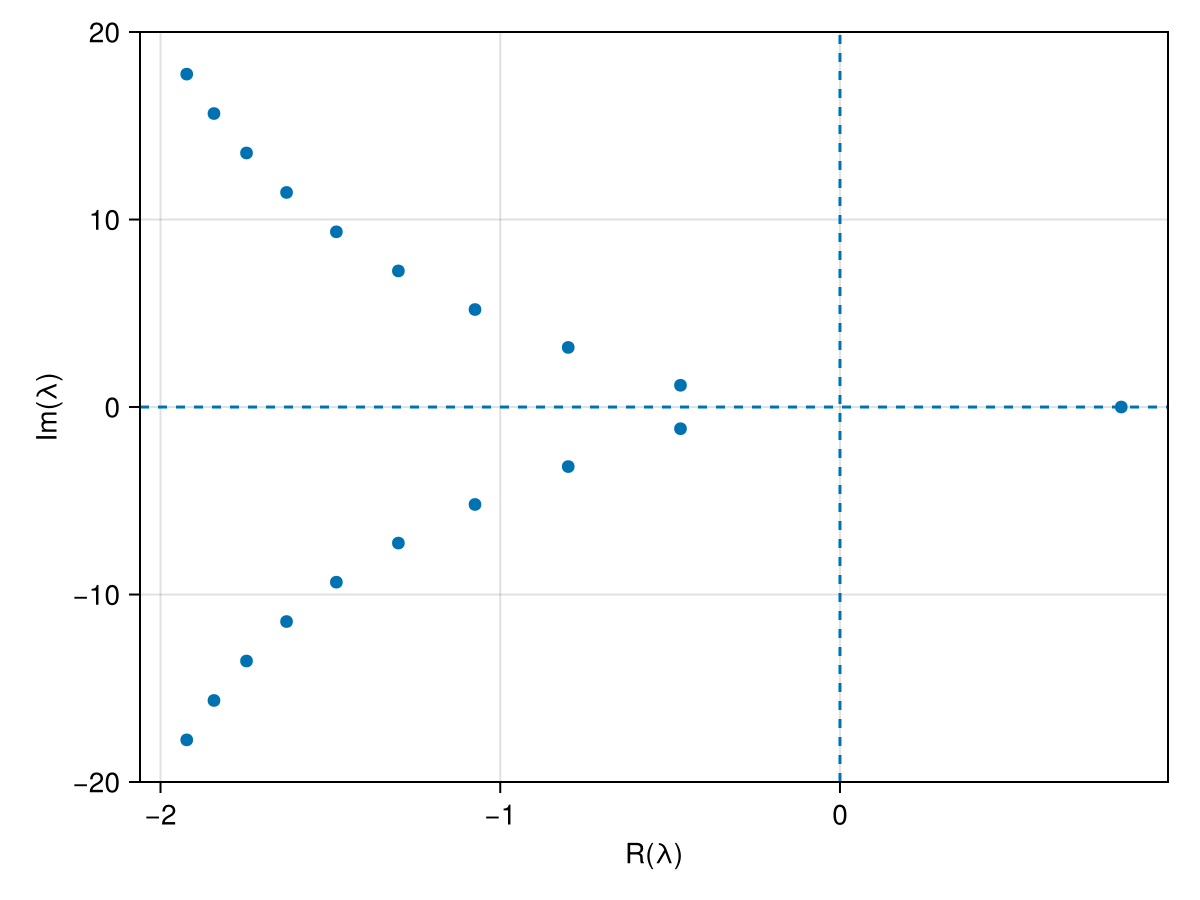

In [39]:
neigs2=length(eigvals2) #number of eigenvalues 

vjvec2=[fill(0.0+0*im, m2) for _ in 1:neigs2] #creates blank array for first eigenvector for the eigenvalues

for i in 1:neigs2
    vjvec2[i]=eigvecs2[:,i][1:m2] #finds first eigenvector for the eigenvalues
end 

stab2_err=fill(NaN, neigs2) #creates blank array for the error of stab_func_DDE
Idm2=Matrix{Float64}(I,m2,m2) #creates 2x2 identity matrix 

for k in 1:neigs2
    ceq_vec2=(eigvals2[k]*Idm2 - A0_2 - A1_2*exp(-(eigvals2[k]*tau1_2))- A2_2*exp(-(eigvals2[k]*tau2_2))-A3_2*exp(-(eigvals2[k]*taus_2)))*vjvec2[k] #finds the value of equation (1) 
    #CHECK THE ABOVE EQUATION LABEL!!!!!
    comp_vec2=ceq_vec2-[0,0]
    stab2_err[k]=norm(comp_vec2) #finds the error of stab_func_DDE
end 

#Assume we accept a tolerance of 10^-7 (1e-7) from 0 we find all eigenvalues that are at least of this tolerance
stab2_acc_indx=findall(<=(1e-7),stab2_err) #finds indices of eigenvalues that are at least of accuracy 1e-7
eig2_acc=eigvals2[stab2_acc_indx] #eignvalues that are at least 1e-7 accurate 

#Plot of eigenvalues that are at least 1e-7 accurate
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="R(λ)",ylabel="Im(λ)")
scatter!(ax2,real(eig2_acc),imag(eig2_acc))
hlines!(ax2,0, linestyle=:dash)
vlines!(ax2,0, linestyle=:dash)
ylims!(ax2,[-20,20])
#xlims!(ax2,[-25,0])
fig2

In [40]:
length(stab2_acc_indx) #number of eigenvalues that are at least 1e-7 accurate

19

Again we see that more than half the eigenvalues are at a suitable accuracy so ```stab_func_DDE``` is pretty accurate and working well.

# Example 3

For the final example we will look at the Mackey-Glass equation. It is 1-dimensional and has a single delay. Again Mackey-Glass is an example demo in DDE-Biftool. The Mackey-Glass equation is:
```math
\begin{align}
  \dot{x}&= \frac{\beta x(t-\tau)}{1+[x(t-\tau)]^n}- \gamma x(t)\\
\end{align}
```
For this system there is an equilibrium at $x^*=0$ and at $x^*=\left( \frac{\beta - \gamma}{\gamma}\right)^{\frac{1}{n}}$. For this example, we'll take $x^*=\left( \frac{\beta - \gamma}{\gamma}\right)^{\frac{1}{n}}$. In the demo for DDE-Biftool, the parameter values are: $\gamma=1, \beta=2, n=10$. I'll pick $\tau=0.2$. Hence for the equilibrium point $x^*=\left( \frac{\beta - \gamma}{\gamma}\right)^{\frac{1}{n}}=1$, the DDE system can be linearised into the form:
```math
\dot{u}=A_0u(t) +A_1u(t-\tau)
```
where $u=x$ (linearised) and the matrices $A_0, A_1$ (to be put in ```A```) are given by:
```math
A_0=-\gamma, \quad A_1=-\beta\left[\frac{(n-1)(1)^{n}-1}{(1+(1)^n)^2}\right]
```
So for the given parameters we the following matrices to put into argument ```A``` of ```stab_func_DDE```:
```math
A_0=-1, \quad A_1=4
```

In [ ]:
m3=1 #1 dimensional system (x)

#Below are the matrices to put into stab_func_DDE (for the parameters given above)
A0_3=[-1] #needs to be in vector/1x1 matrix form
A1_3=[4] #needs to be in vector/1x1 matrix form

#The delays of system
tau1_3=0.2
N3=150 #N3=30, 50, 100 not giving half accurate; N3=150 gives exactly half accurate (maybe has to do with it not being a nice function???)
#Talk about how you need to ensure N3 is high enough???


stab3, eigvals3, eigvecs3=stab_func_DDE([A0_3, A1_3],[tau1_3],N3, eigvecs=1) #the function outputs the stability, eigenvalues and eigenvectors (eigvecs≠0)

(0, ComplexF64[-9602.882382849266 - 2069.8352185500075im, -9602.882382849266 + 2069.8352185500075im, -7133.484779563843 - 4899.097078385561im, -7133.484779563843 + 4899.097078385561im, -5063.147314043705 - 19293.59194957036im, -5063.147314043705 + 19293.59194957036im, -4342.874662886328 - 5512.04781992189im, -4342.874662886328 + 5512.04781992189im, -2477.0328767707956 - 4975.558723466886im, -2477.0328767707956 + 4975.558723466886im  …  -18.10949221933887 + 148.65268678498592im, -16.930936024550572 - 117.13384026423691im, -16.930936024550572 + 117.13384026423691im, -15.38435491158575 - 85.56099505600328im, -15.38435491158575 + 85.56099505600328im, -13.125028028414512 - 53.87093998594912im, -13.125028028414512 + 53.87093998594912im, -8.788537102689437 - 21.849867440169405im, -8.788537102689437 + 21.849867440169405im, 1.7940360279905851 + 0.0im], ComplexF64[0.0002914550732698142 - 6.282767807659101e-5im 0.0002914550732698142 + 6.282767807659101e-5im … -0.008142304687134935 - 0.02284232272

Again we check the accuracy of ```stab_func_DDE``` by substituting all eigenvalues and their first eigenvector into Equation (1)

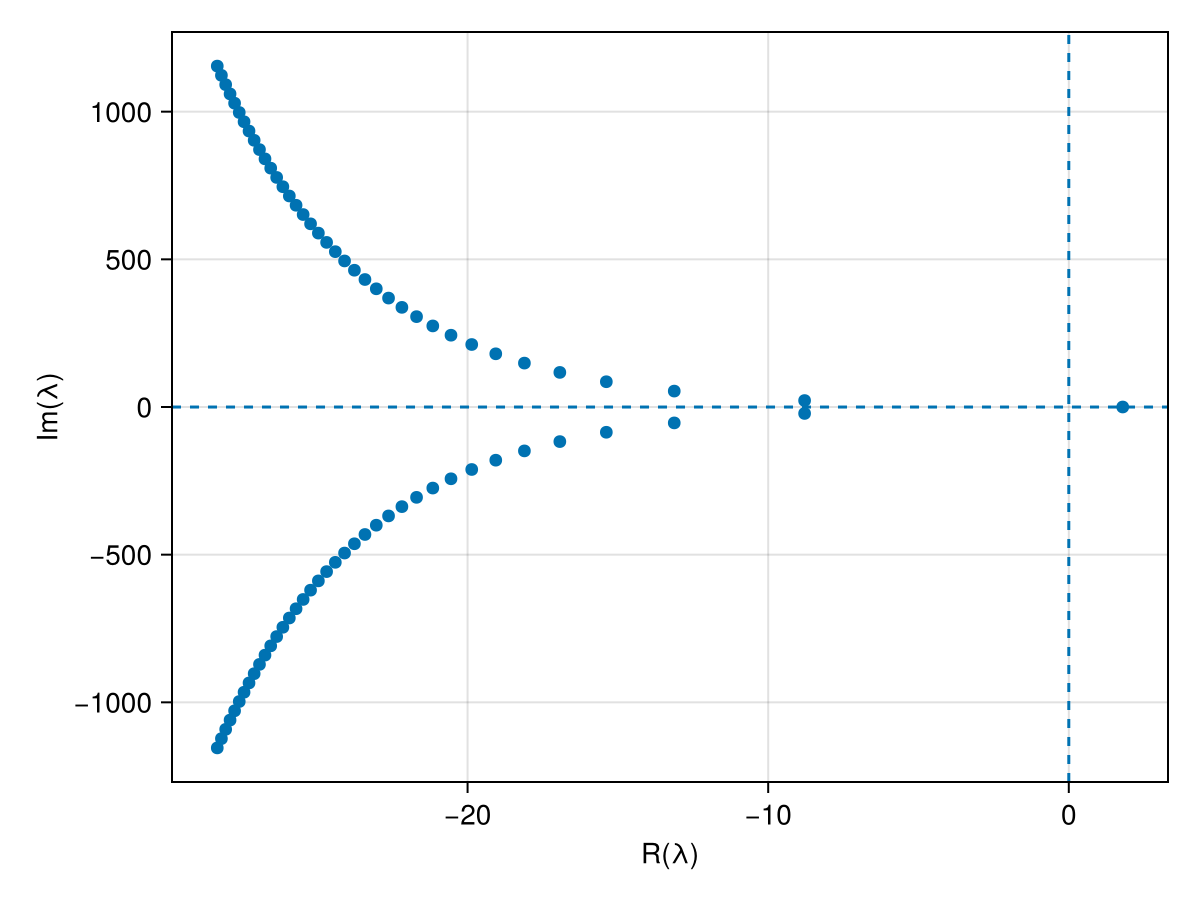

In [72]:
neigs3=length(eigvals3) #number of eigenvalues 

vjvec3=[fill(0.0+0*im, m3) for _ in 1:neigs3] #creates blank array for first eigenvector for the eigenvalues

for i in 1:neigs3
    vjvec3[i]=eigvecs3[:,i][1:m3] #finds first eigenvector for the eigenvalues
end 

stab3_err=fill(NaN, neigs3) #creates blank array for the error of stab_func_DDE
Idm3=Matrix{Float64}(I,m3,m3) #creates 2x2 identity matrix 

for k in 1:neigs3
    ceq_vec3=(eigvals3[k]*Idm3 - A0_3 - A1_3*exp(-(eigvals3[k]*tau1_3)))*vjvec3[k] #finds the value of equation (1) 
    #CHECK THE ABOVE EQUATION LABEL!!!!!
    comp_vec3=ceq_vec3-[0]
    stab3_err[k]=norm(comp_vec3) #finds the error of stab_func_DDE
end 

#Assume we accept a tolerance of 10^-7 (1e-7) from 0 we find all eigenvalues that are at least of this tolerance
stab3_acc_indx=findall(<=(1e-7),stab3_err) #finds indices of eigenvalues that are at least of accuracy 1e-7
eig3_acc=eigvals3[stab3_acc_indx] #eignvalues that are at least 1e-7 accurate 

#Plot of eigenvalues that are at least 1e-7 accurate
fig3=Figure()
ax3=Axis(fig3[1,1],xlabel="R(λ)",ylabel="Im(λ)")
scatter!(ax3,real(eig3_acc),imag(eig3_acc))
hlines!(ax3,0, linestyle=:dash)
vlines!(ax3,0, linestyle=:dash)
#ylims!(ax3,[-20,20])
#xlims!(ax2,[-25,0])
fig3

In [73]:
length(stab3_acc_indx)

75

## References 

1. D. Breada, S. Maset, R. Vermiglio. *TACE-DDE: a Tool for Robust Analysis
and Characteristic Equations for Delay Differential Equations*, volume 388, pages 145-155, 2009